# Load packages

In [1]:
using CMBLensing
using CMBLensing: cache, δlnΠᶠ_δfϕ, get_ℓ⁴Cℓ
using JLD
using PyPlot
using Optim

INFO: Recompiling stale cache file /home/marius/.julia/lib/v0.6/CMBLensing.ji for module CMBLensing.


# Initialization

## Load power spectra

Load some power-spectra we've precomputed with CLASS (these have $r=0.05$),

In [2]:
Cℓf = load("fidcls_r05.jld","Cℓf");
Cℓf̃ = Dict(k=>Cℓf[Symbol("ln_$k")] for (k,v) in Cℓf if Symbol("ln_$k") in keys(Cℓf));

Chose the noise power-spectra we are assuming,

In [3]:
Cℓn = noisecls(1,beamFWHM=3,ℓknee=100);

Plot these up for reference,

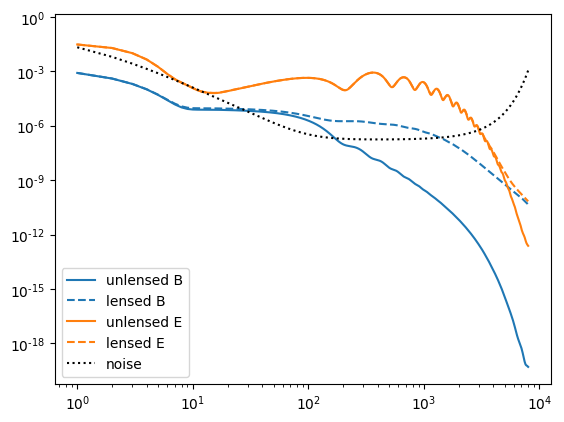

PyObject <matplotlib.legend.Legend object at 0x7ff28a90a8d0>

In [4]:
l,=loglog(Cℓf[:bb])
loglog(Cℓf̃[:bb],"--",c=l[:get_color]())
l,=loglog(Cℓf[:ee])
loglog(Cℓf̃[:ee],"--",c=l[:get_color]())
loglog(Cℓn[:bb],"k:")
legend(["unlensed B","lensed B","unlensed E","lensed E","noise"])

## Flat-sky configuration

First, we set up the size and pixelization of our flat-sky maps,

In [5]:
Θpix = 3 # arcmin pixels
nside = 128 # pixels per side

T = Float32
P = Flat{Θpix,nside}

CMBLensing.Flat{3,128}

This converts the $C_\ell$ angular power spectra from above into flat-sky 2D covariances,

In [6]:
SS,ks =(S0,S2),(:tt,:ee,:bb,:te)
Cn = Cℓ_to_cov(T,P,SS..., Cℓn[:ℓ], (Cℓn[k] for k=ks)...)
Cf = Cℓ_to_cov(T,P,SS..., Cℓf[:ℓ], (Cℓf[k] for k=ks)...)
Cf̃ = Cℓ_to_cov(T,P,SS..., Cℓf[:ℓ], (Cℓf̃[k] for k=ks)...)
Cϕ = Cℓ_to_cov(T,P,S0,    Cℓf[:ℓ], Cℓf[:ϕϕ]);

## Generate simulated data

Lets simulate a $\phi$ map which will be the "truth",

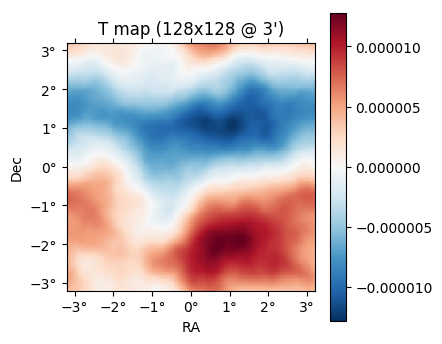

In [7]:
ϕ = simulate(Cϕ)
plot(ϕ);

And a "true" unlensed field, $f$,

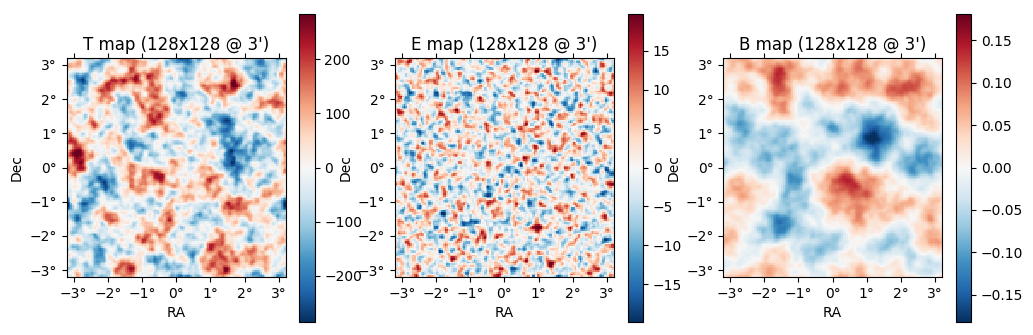

In [8]:
f = simulate(Cf)
plot(f);

We can compute the "true" lensed field,

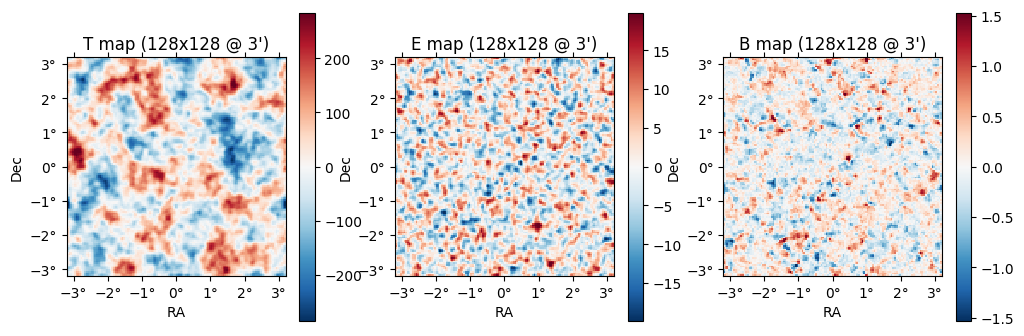

In [9]:
L = LenseFlow
f̃ = L(ϕ)*f
plot(f̃);

Our simulated data is then the lensed field $\tilde f$, with a sample of the noise,

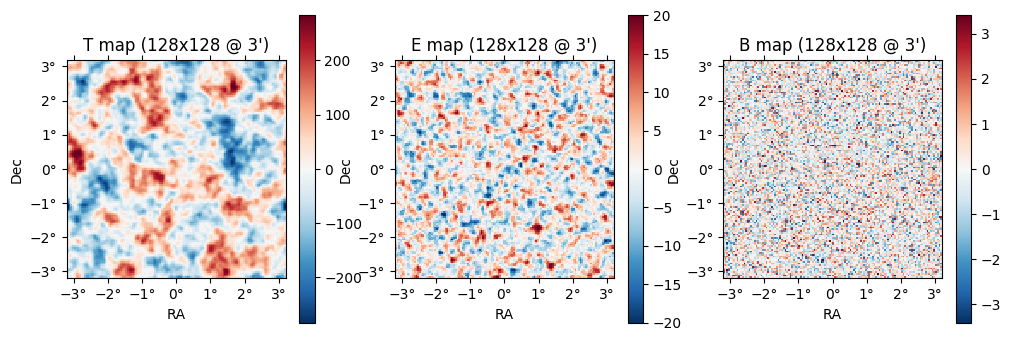

In [10]:
d = f̃ + simulate(Cn);
plot(d);

## Masking

This run will be simple, we'll use just an $\ell<3000$ cut on the data. 

We also need to mask the Nyquist frequency because EB-QU conversion is not numerically exact with an even number of pixels if you only store the real part of the map (as we do, for speed).

In [11]:
ℓmax_data = 3000

3000

In [12]:
# field prior term mask
Ml = ones(Complex{T},nside÷2+1,nside)
i = indexin([-FFTgrid(T,P).nyq],FFTgrid(T,P).k)[1]
Ml[:,i] = Ml[i,:] = 0
Mff = FullDiagOp(FlatTEBFourier{T,P}(repeated(Ml,3)...))
Mf = Squash * Mff * Squash

# data mask
Mdf = Mff * FullDiagOp(FlatTEBFourier{T,P}(repeated(Cℓ_2D(P,1:ℓmax_data,ones(ℓmax_data)),3)...))
Md = Squash * Mdf * Squash

# ϕ prior mask
Mϕ = Squash;

# The algorithm

## Inputs

The algorithm needs as input the cooling weights, which are computed from some simulations. We've precomputed these for this particular run. The weights depend on the mask, beam, noise levels, pixelization, the number of steps you intend to run the algorithm, and loosely on a fiducial cosmology. Using the "wrong" weights means only sub-optimal convergence speed, not errors in the final answer. 

In [13]:
wℓᵢ = [0; load("weights_128example.jld","wℓ"); 1];

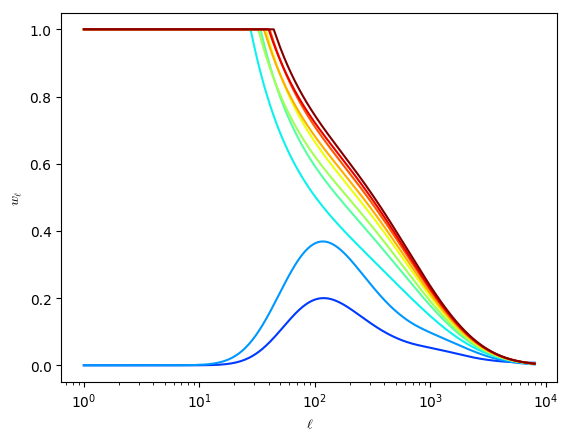

In [14]:
for (i,wℓ) in enumerate(wℓᵢ)
    semilogx(wℓ,c=get_cmap("jet",length(wℓᵢ))(i))
end
xlabel(raw"$\ell$")
ylabel(raw"$w_\ell$");

The starting point for the algorithm is simply $\phi=0$

In [15]:
ϕcur = zero(FlatS0Map{T,P});

You don't specify starting points for $f$ and $\tilde f$ 

In [16]:
fcur, f̃cur = nothing, nothing;

## Run it!

In [17]:
global χ² # this will track the χ² w.r.t. the cooling covariance of the current step

@time for (i,wℓ) in enumerate(wℓᵢ)

    # compute the cooling covariance
    Ĉf = Cℓ_to_cov(T,P,SS..., Cℓf[:ℓ], ((@. sign(Cℓf̃[k])*abs(Cℓf̃[k])^(1-wℓ)*abs(Cℓf[k])^wℓ) for k=ks)...)
    
    # for convenience below, the "dataset" holds data, covariances, and mask
    ds = DataSet(d, Cn, Ĉf, Cϕ, Md, Mf, Mϕ)
    
    # ----------------------
    # the Wiener filter step
    # ----------------------
    
    let L = (i==0 ? IdentityOp : cache(L(ϕcur))), # in the first step ϕ=0 so no lensing operation is necessary
        P = nan2zero.(sqrtm((nan2zero.(Mdf * Cn^-1) .+ nan2zero.(Mff * Ĉf^-1)))^-1); # our preconditioner
        
        A = L'*(Md'*(Cn^-1)*Md*L) + Mf'*Ĉf^-1*Mf 
        b = L'*(Md'*(Cn^-1)*Md*d)
        fcur = pcg(P, A, b,                                    # here's the conjugate gradient
                  fcur==nothing ? 0*b : (Squash*(P\fcur)),     # after the first step, use the previous solution as the starting point
                  tol=1e-1)[1]
        f̃cur = L*fcur
    end
    
    # ----------
    # the ϕ step
    # ----------
    
    if i!=endof(wℓᵢ) # ϕ step is skipped for the last iteration
        
        # compute gradient
        ϕnew = Mϕ*Cϕ*(δlnΠᶠ_δfϕ(fcur,ϕcur,ds) * δfϕ_δf̃ϕ(L(ϕcur),fcur,f̃cur))[2]
        
        # do linesearch
        res = optimize(α->(-lnP(1,f̃cur,(1-α)*ϕcur+α*ϕnew,ds,L)), T(0), T(0.1), abs_tol=1e-2)
        α = res.minimizer
        χ² = 2res.minimum
        
        # update current ϕ
        ϕcur = (1-α)*ϕcur+α*ϕnew
    else
        χ² = -2lnP(1,f̃cur,ϕcur,ds,L) # final iteration just compute the final likelihood 
    end

    @show i, χ²
        
end

(i, χ²) = (1, 26338.115f0)
(i, χ²) = (2, 26385.416f0)
(i, χ²) = (3, 26345.236f0)
(i, χ²) = (4, 26374.656f0)
(i, χ²) = (5, 26373.309f0)
(i, χ²) = (6, 26318.117f0)
(i, χ²) = (7, 26266.26f0)
(i, χ²) = (8, 26196.424f0)
(i, χ²) = (9, 26168.477f0)
(i, χ²) = (10, 26138.074f0)
(i, χ²) = (11, 26100.38f0)
(i, χ²) = (12, 27647.781f0)
 93.745756 seconds (65.02 M allocations: 101.837 GiB, 20.25% gc time)


# Examine results

The expected value of the final best-fit $\chi^2 (i.e. -2\log \mathcal{P}$) is given by the number of unmasked degrees of freedom in the data (remember we applied an $\ell<3000$ data mask so this number is slightly lower than the the total number of pixels in IQU which would be  $3\cdot128^2$)

In [18]:
dof = 3real(sum(2Mdf.f[:Tl]))

27150.0f0

Here's how far away our final $\chi^2$ is from this expectation, in units of $\sigma$,

In [19]:
(χ² - dof)/sqrt(2dof)

2.1361837f0

Here's the best-fit $\phi$ (right) relative to the truth (left),

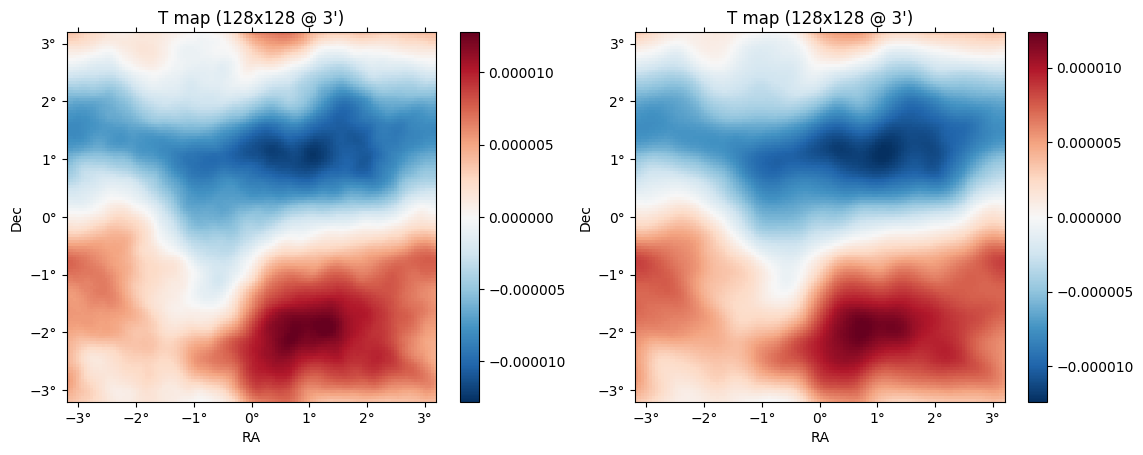

In [20]:
plot([ϕ,ϕcur]');

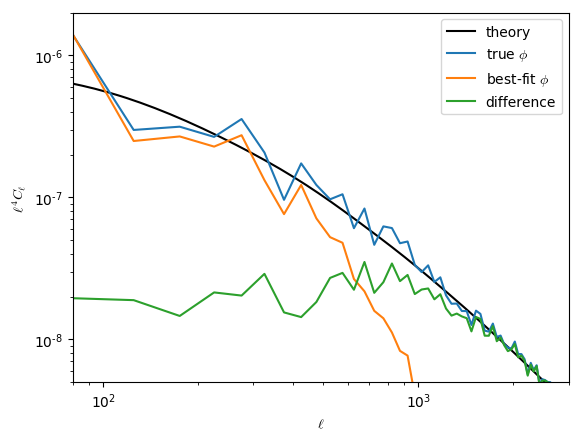

PyObject <matplotlib.text.Text object at 0x7ff28163a0b8>

In [21]:
loglog(Cℓf[:ℓ],(@. Cℓf[:ℓ]^4 * Cℓf[:ϕϕ]),"k")
loglog(get_ℓ⁴Cℓ(ϕ)...)
loglog(get_ℓ⁴Cℓ(ϕcur)...)
loglog(get_ℓ⁴Cℓ(ϕcur-ϕ)...)
xlim(80,3000)
ylim(5e-9,2e-6)
legend(["theory",raw"true $\phi$", raw"best-fit $\phi$", "difference"])
xlabel(raw"$\ell$")
ylabel(raw"$\ell^4 C_\ell$")

The best-fit unlensed field (bottom row) relative to truth (top row),

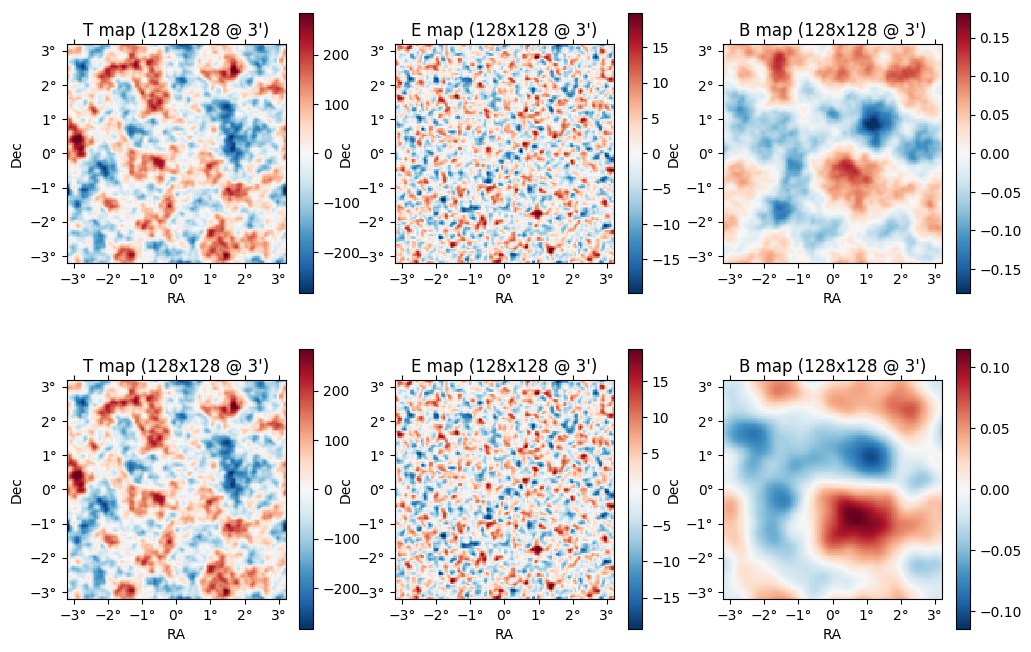

In [22]:
plot([f,fcur]);

The best-fit lensed field (bottom row) relative to truth (top row),

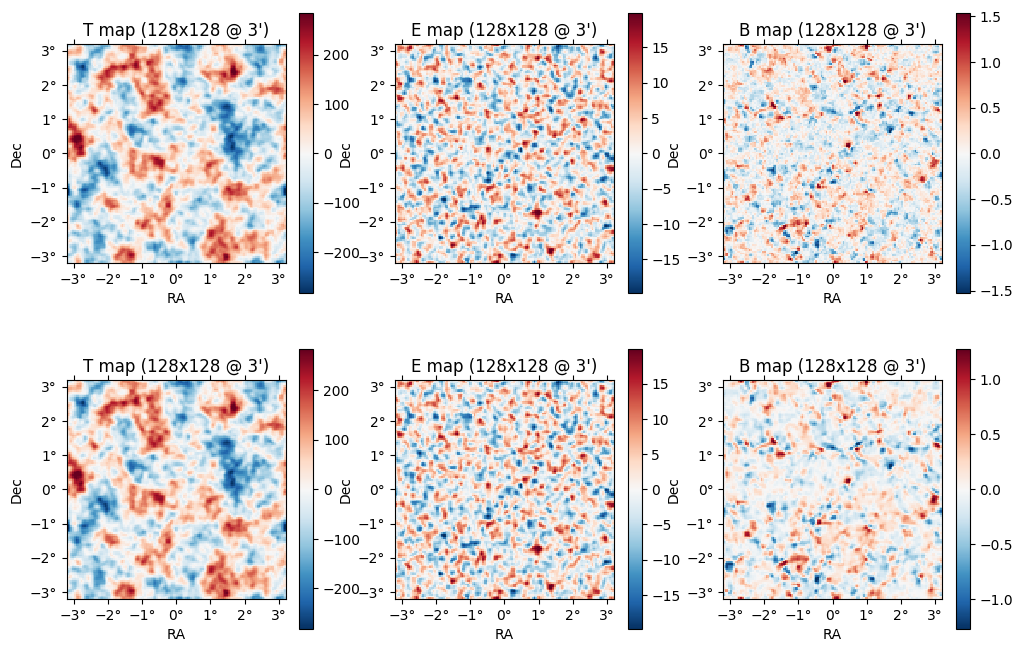

In [23]:
plot([f̃,f̃cur]);